In [3]:
import sklearn
from tsai.basics import *
my_setup(sklearn)
import config

os              : Windows-10-10.0.19045-SP0
python          : 3.11.5
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
sklearn         : 1.3.2
torch           : 2.1.1+cpu
device          : cpu
cpu cores       : 6
threads per cpu : 1
RAM             : 15.8 GB
GPU memory      : [2.0] GB


In [4]:
import pandas as pd
df=pd.read_csv('D:/project/aircompressordata.csv')
df=df.drop(config.DROP_COLOUMNS,axis=1)
print(df.columns)
df.head(5)

AttributeError: module 'config' has no attribute 'DROP_COLOUMNS'

In [6]:
'''
datetime_col=config.DATETIME_COL
freq=config.FREQUENCY
coloumns=config.COLOUMNS
method=config.METHOD
value=config.VALUE
'''
'''
preproc_pipe=sklearn.pipeline.Pipeline([
    ('shrinker',TSShrinkDataFrame()),
    ('drop_duplicates',TSDropDuplicates(datetime_col=datetime_col)),
    ('add_mts',TSAddMissingTimestamps(datetime_col=datetime_col,freq=freq)),
    ('fill_missing',TSFillMissing(columns=coloumns,method=method,value=value)),
    ],
    verbose=True)
'''
#mkdir('data', exist_ok=True,parents=True)
#save_object(preproc_pipe,'data/preproc_pipe.pkl')
preproc_pipe=load_object('data/preproc_pipe.pkl')

df=preproc_pipe.fit_transform(df)

Initial memory usage: 1.58 MB   
Final memory usage  : 1.15 MB    (-27.2%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.1s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


In [7]:
df.head()

timestamp data_id  air_inlet_temp_deg_f  average_cfm  average_kw  \
0 2021-06-10 00:00:00       0                  76.0         74.0       382.0   
1 2021-06-10 01:00:00       1                  79.0         76.0       382.0   
2 2021-06-10 02:00:00       2                  75.0         82.0       436.0   
3 2021-06-10 03:00:00       3                  85.0        100.0       472.0   
4 2021-06-10 04:00:00       4                  83.0         96.0       468.0   

   compressor_room_air_generated_cfm  compressor_room_energy_cosumed_kwh  \
0                              382.0                                74.0   
1                              382.0                                76.0   
2                              436.0                                82.0   
3                              472.0                               100.0   
4                              468.0                                96.0   

   ideal_specific_power_kw_100cfm  specific_power_kw_100cfm  \
0                            18.6                 19.370001   
1                            18.6                 19.900000   
2                            18.6                 18.809999   
3                            18.6                 21.190001   
4                            18.6                 20.510000   

   percentage_loading_based_on_air_supplied_design_600cfm  device_id  
0                                                    64.0        2.0  
1                                                    64.0        2.0  
2                                                    73.0        2.0  
3                                                    79.0        2.0  
4                                                    78.0        2.0

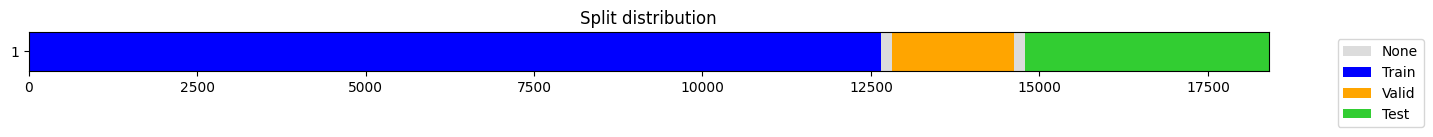

((#12647) [0,1,2,3,4,5,6,7,8,9...],
 (#1807) [12814,12815,12816,12817,12818,12819,12820,12821,12822,12823...],
 (#3613) [14788,14789,14790,14791,14792,14793,14794,14795,14796,14797...])

In [8]:
fcst_history= config.FCST_HISTORY
fcst_horizon= config.FCST_HORIZON
valid_size= config.VALID_SIZE
test_size= config.TEST_SIZE

splits=get_forecasting_splits(df,fcst_history=fcst_history,fcst_horizon=fcst_horizon,datetime_col=datetime_col,
                              valid_size=valid_size,test_size=test_size)

splits

In [9]:
coloumns=config.COLOUMNS
train_split=splits[0]

'''
exp_pipe=sklearn.pipeline.Pipeline([
    ('scaler',TSStandardScaler(columns=coloumns)),
    ],
    verbose=True)
'''

#save_object(exp_pipe,'data/exp_pipe.pkl')
exp_pipe=load_object('data/exp_pipe.pkl')

df_scaled=exp_pipe.fit_transform(df,scaler__idxs=train_split)

df_scaled

AttributeError: module 'config' has no attribute 'COLOUMNS'

In [10]:
x_vars=config.AIR_COLOUMNS
y_vars=config.AIR_COLOUMNS

In [11]:
X,y=prepare_forecasting_data(df,fcst_history=fcst_history,fcst_horizon=fcst_horizon,x_vars=x_vars,y_vars=y_vars)
X.shape , y.shape

((18401, 7, 200), (18401, 7, 168))

In [33]:
'''
arch_config=dict(
    n_layers=3,
    n_heads=4,
    d_model=16,
    d_ff=128,
    attn_dropout=0.0,
    dropout=0.3,
    patch_len=24,
    stride=2,
    padding_patch=True,
)
'''

arch_config=config.ARCH_CONFIG

In [42]:
learn=TSForecaster(X,y,splits=splits,
                   batch_size=16,path="models",
                   pipelines=[preproc_pipe,exp_pipe],
                   arch="InceptionTimePlus",
                   #arch_config=arch_config,
                   metrics=[mae,mape],
                   cbs=ShowGraph())

In [43]:
learn.summary()

not enough values to plot a chart


InceptionTimePlus (Input shape: 16 x 7 x 200)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 200       
Conv1d                                    224        True      
Conv1d                                    39936      True      
Conv1d                                    19456      True      
Conv1d                                    9216       True      
MaxPool1d                                                      
____________________________________________________________________________
                     16 x 32 x 200       
Conv1d                                    224        True      
____________________________________________________________________________
                     16 x 128 x 200      
Concat                                                         
BatchNorm1d                               256        True      
ReLU                                                           
__________________________________

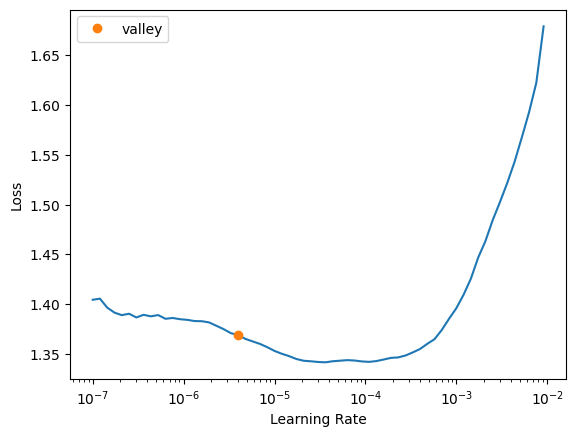

In [44]:
lr_max=learn.lr_find().valley

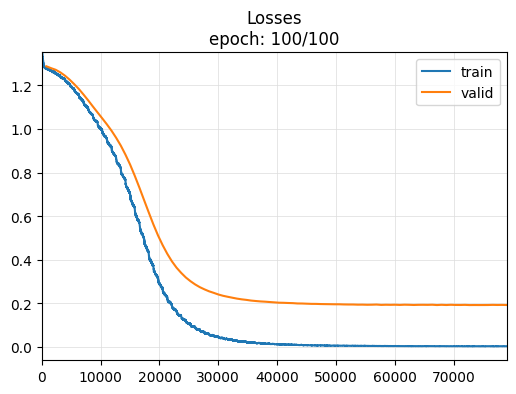

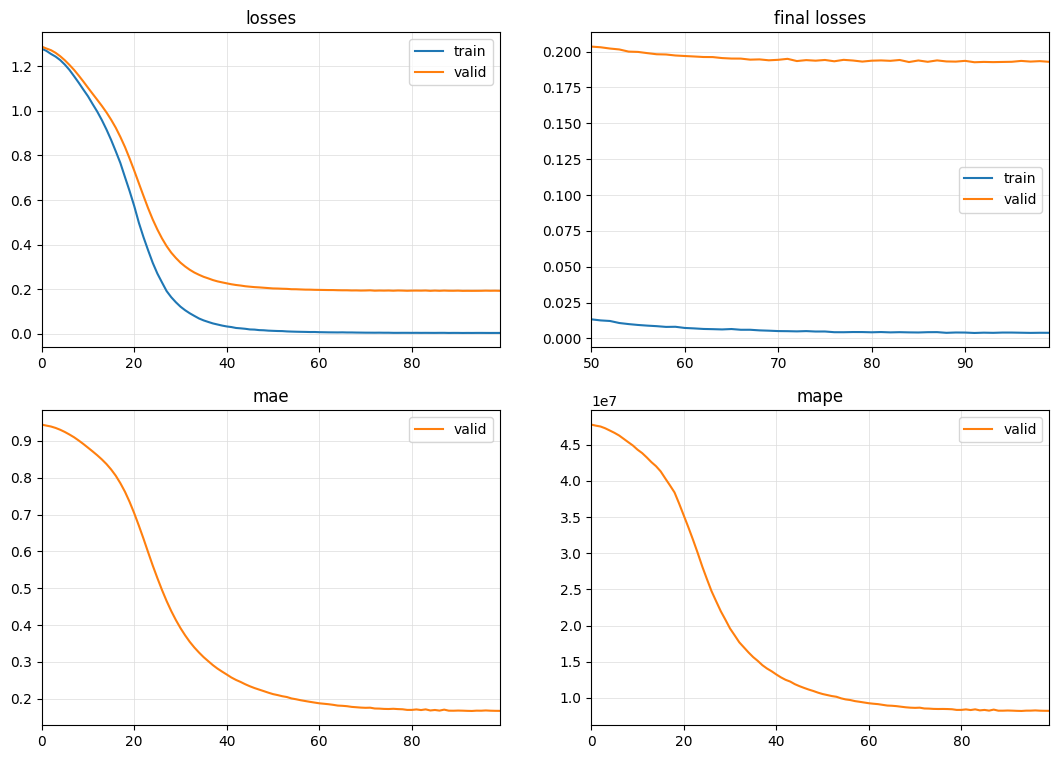

In [45]:
n_epochs=100

learn.fit_one_cycle(n_epoch=n_epochs,lr_max=lr_max)
learn.export('InceptionTime2.pt')

In [12]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

learn=load_learner('models/AirInceptionTime.pt')
y_test_preds, *_=learn.get_X_preds(X[splits[2]])
y_test_preds=to_np(y_test_preds)
print(y_test_preds.shape)

y_test=y[splits[2]]

print(mean_squared_error(y_test.flatten(),y_test_preds.flatten()))
print(mean_absolute_error(y_test.flatten(),y_test_preds.flatten()))
print(mean_absolute_percentage_error(y_test.flatten(),y_test_preds.flatten()))

(3613, 7, 168)
568426.0068151207
607.3238199775309
7.578087851219942


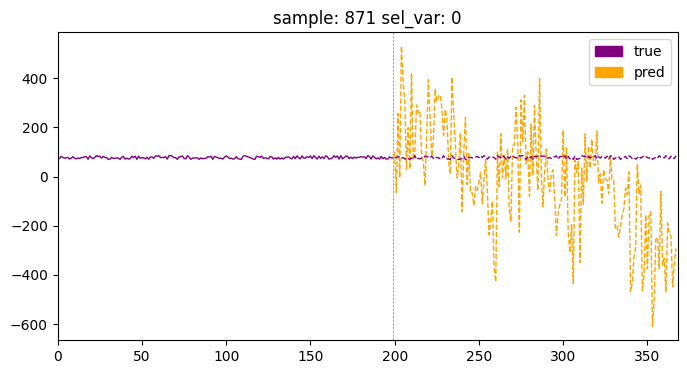

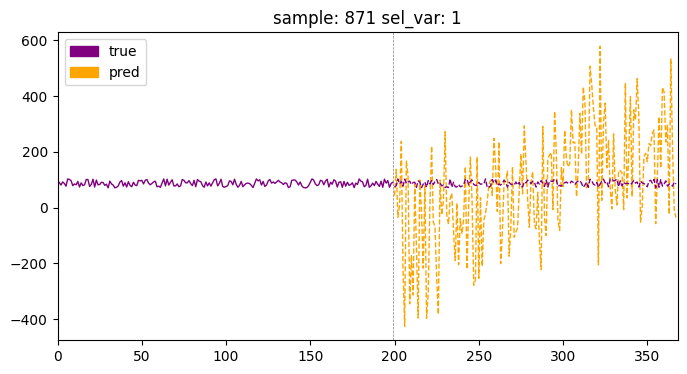

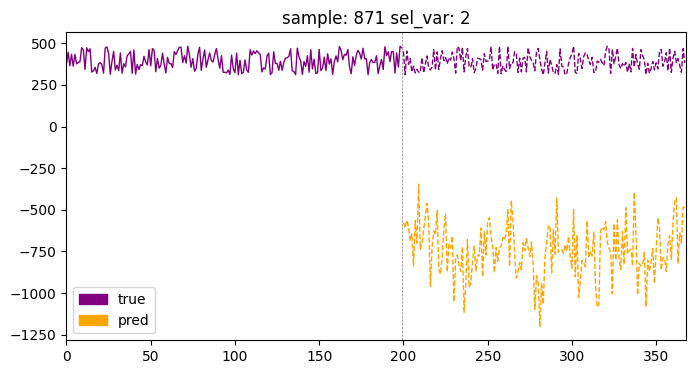

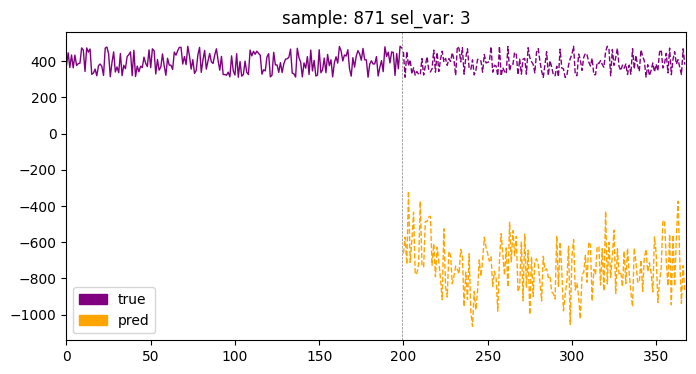

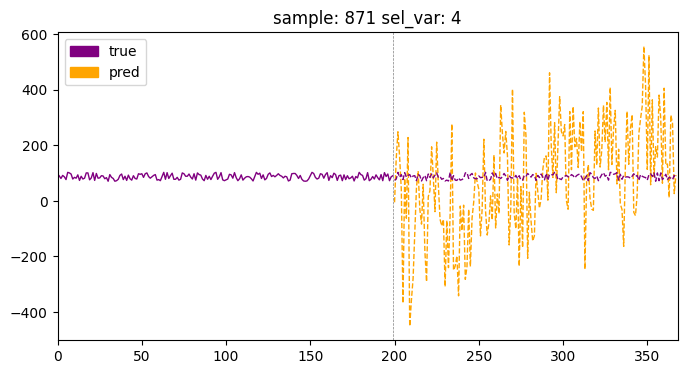

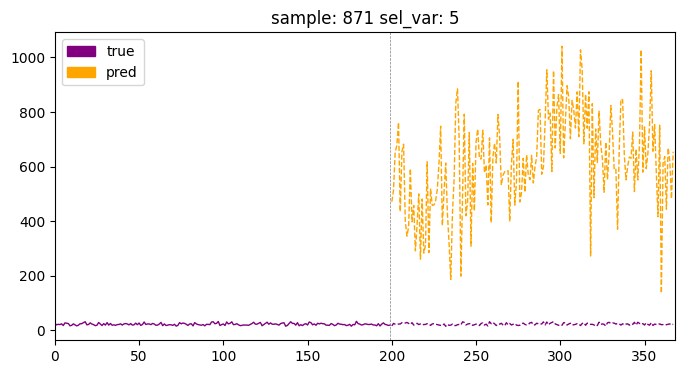

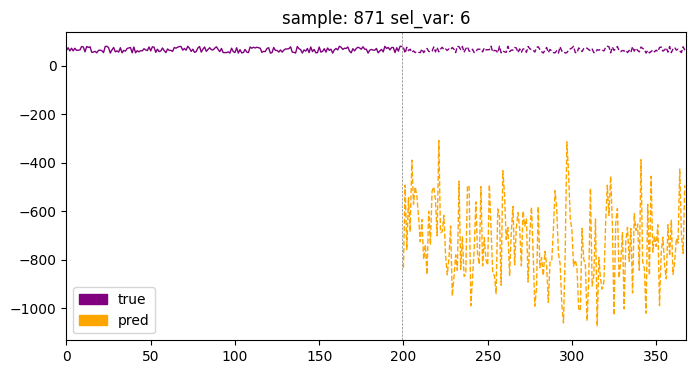

In [13]:
X_test=X[splits[2]]
plot_forecast(X_test,y_test,y_test_preds,sel_vars=True)

In [7]:
fcst_date="2023-07-31 23:00:00"
dates=pd.date_range(start=None,end=fcst_date,periods=config.FCST_HISTORY,freq=config.FREQUENCY)
dates

DatetimeIndex(['2023-07-23 16:00:00', '2023-07-23 17:00:00',
               '2023-07-23 18:00:00', '2023-07-23 19:00:00',
               '2023-07-23 20:00:00', '2023-07-23 21:00:00',
               '2023-07-23 22:00:00', '2023-07-23 23:00:00',
               '2023-07-24 00:00:00', '2023-07-24 01:00:00',
               ...
               '2023-07-31 14:00:00', '2023-07-31 15:00:00',
               '2023-07-31 16:00:00', '2023-07-31 17:00:00',
               '2023-07-31 18:00:00', '2023-07-31 19:00:00',
               '2023-07-31 20:00:00', '2023-07-31 21:00:00',
               '2023-07-31 22:00:00', '2023-07-31 23:00:00'],
              dtype='datetime64[ns]', length=200, freq='H')

In [9]:
#df=pd.read_csv('D:/project/aircompressordata.csv')
#df=preproc_pipe.fit_transform(df)

new_df=df[df[config.DATETIME_COL].isin(dates)].reset_index(drop=True)
new_df

Empty DataFrame
Columns: [air_inlet_temp_deg_f, average_cfm, average_kw, compressor_room_air_generated_cfm, compressor_room_energy_cosumed_kwh, specific_power_kw_100cfm, percentage_loading_based_on_air_supplied_design_600cfm, timestamp]
Index: []

In [3]:
from tsai.inference import load_learner

predict=load_learner('models/InceptionTime2.pt')
new_df=predict.transform(new_df)

new_df

NameError: name 'new_df' is not defined

In [ ]:
x_feat=new_df.columns[1:]
new_x,__=prepare_forecasting_data(new_df,fcst_history=fcst_history,fcst_horizon=0,x_vars=x_vars,y_vars=y_vars)
new_x.shape

(1, 7, 200)

In [ ]:
new_scaled_preds, *_ = learn.get_X_preds(new_x)

new_scaled_preds=to_np(new_scaled_preds).swapaxes(1,2).reshape(-1,len(y_vars))
dates=pd.date_range(start=fcst_date, periods=fcst_horizon+1,freq='1H')[1:]
preds_df=pd.DataFrame(dates,columns=[datetime_col])
preds_df.loc[:, y_vars]=new_scaled_preds
preds_df=learn.inverse_transform(preds_df)

preds_df

ValueError: Length of values (72) does not match length of index (168)